In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.model.mlm.pet_for_text_classification import train
from src.preprocessing.pet.pet_for_text_classification_dataset import PETDatasetForClassification
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "PET"
dataset_name = "SST5"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Loading dataset

In [4]:
tokenizer= AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
sst5_dataset = load_dataset("SetFit/sst5")

In [6]:
np.unique(sst5_dataset['train']['label_text'])

array(['negative', 'neutral', 'positive', 'very negative',
       'very positive'], dtype='<U13')

In [7]:
classes_names = np.unique(sst5_dataset['train']['label_text'])

tokenizer.add_tokens(['very positive', 'very negative'])

num_classes = len(classes_names)
num_classes

5

In [8]:
classes2idx = {
    label: idx for idx, label in enumerate(classes_names) 
}

idx2classes = {
    idx: label for idx, label in enumerate(classes_names) 
}

## Preprocessing

In [54]:
def pattern1(text: str, tokenizer : AutoTokenizer):
    return "In all it was a " + tokenizer.mask_token + "." + text  

def pattern2(text: str, tokenizer : AutoTokenizer):
    return text + " In summary it was " + tokenizer.mask_token 

In [55]:
def preprocess(text : List[str], labels : List[int], pattern : callable):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2classes[labels[idx]]
        text_ = text[idx]

        processed_text.append(pattern(text_, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [56]:
verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(classes_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(classes_names)}

In [57]:
total_history = {}

## Two shots

In [58]:
n_shots = 2

In [59]:
train_text, train_labels = get_n_shots_per_class(
    sst5_dataset['train']['text'],
    sst5_dataset['train']['label'],
    n_shots=n_shots,
    num_classes=num_classes
)
val_text, val_labels = get_n_shots_per_class(
    sst5_dataset['test']['text'],
    sst5_dataset['test']['label'],
    n_shots=100,
    num_classes=num_classes
)

In [60]:
processed_text_train, labels_train = preprocess(
    train_text,
    train_labels,
    pattern2
)

processed_text_val, labels_val = preprocess(
    val_text,
    val_labels,
    pattern2
)

In [61]:
processed_text_train

["final verdict : you 've seen it all before . In summary it was [MASK]",
 "lacks the inspiration of the original and has a bloated plot that stretches the running time about 10 minutes past a child 's interest and an adult 's patience . In summary it was [MASK]",
 'apparently reassembled from the cutting-room floor of any given daytime soap . In summary it was [MASK]',
 "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes . In summary it was [MASK]",
 'the entire movie is filled with deja vu moments . In summary it was [MASK]',
 'um , no. . In summary it was [MASK]',
 'this is a visually stunning rumination on love , memory , history and the war between art and commerce . In summary it was [MASK]',
 "jonathan parker 's bartleby should have been the be-all-end-all of the modern-office anomie films . In summary it was

In [62]:
train_dataset = PETDatasetForClassification(
    processed_text_train,
    labels_train,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)

In [63]:
train_dataloader = DataLoader(train_dataset)
val_dataloader =DataLoader(val_dataset)

In [64]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device)
model.resize_token_embeddings(len(tokenizer.vocab))

history, confusion_matrix = train(
    train_dataloader,
    val_dataloader,
    num_classes,
    model,
    verbalizer,
    tokenizer,
    alpha = 1e-5,
    n_epochs=20
)

total_history[f'{n_shots} shots'] = history

100%|██████████| 500/500 [00:05<00:00, 88.70it/s]


In [65]:
best_epoch = np.argmax(history)
best_f1 = np.max(history)

Text(0.5, 1.0, 'PET training results- SST5 - 2 shots')

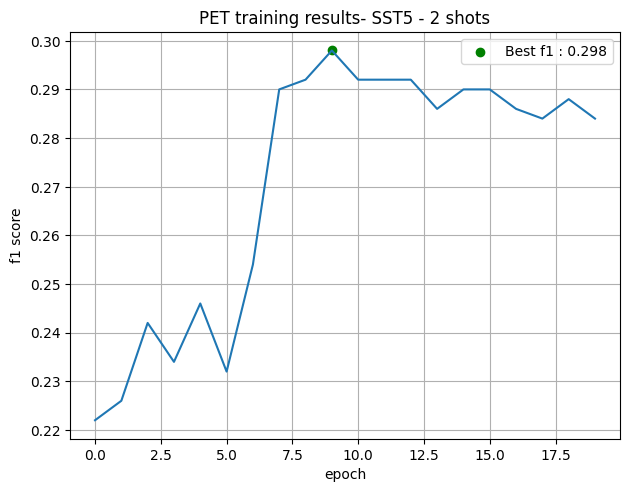

In [66]:
plt.plot(history)
plt.scatter(
    [best_epoch], 
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title(f"PET training results- {dataset_name} - {n_shots} shots")

Text(0.5, 1.0, '\n    Confusion matrix\n    PET - 2 shots SST5\n')

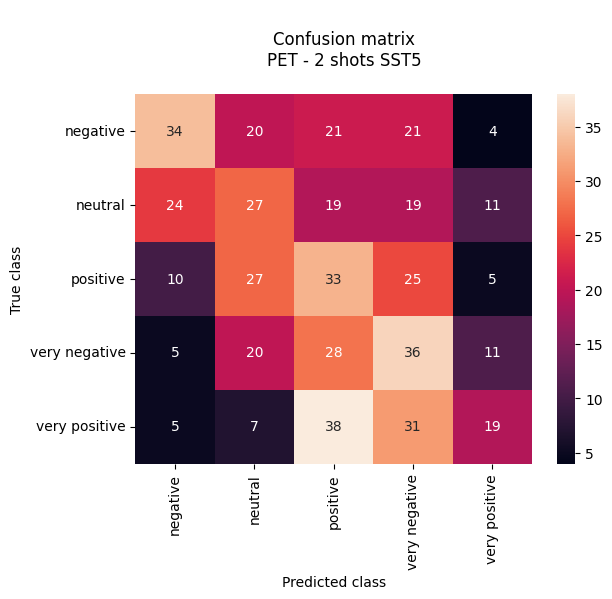

In [67]:
confusion_df = pd.DataFrame(confusion_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in classes2idx.items()})\
    .rename(index = {v:k for k, v in classes2idx.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix
    PET - {n_shots} shots {dataset_name}
''')

## 5 shots

In [76]:
n_shots = 5

In [77]:
train_text, train_labels = get_n_shots_per_class(
    sst5_dataset['train']['text'],
    sst5_dataset['train']['label'],
    n_shots=n_shots,
    num_classes=num_classes
)
val_text, val_labels = get_n_shots_per_class(
    sst5_dataset['test']['text'],
    sst5_dataset['test']['label'],
    n_shots=100,
    num_classes=num_classes
)

In [78]:
processed_text_train, labels_train = preprocess(
    train_text,
    train_labels,
    pattern2
)

processed_text_val, labels_val = preprocess(
    val_text,
    val_labels,
    pattern2
)

In [79]:
train_dataset = PETDatasetForClassification(
    processed_text_train,
    labels_train,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)

In [80]:
train_dataloader = DataLoader(train_dataset)
val_dataloader =DataLoader(val_dataset)

In [81]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device)
model.resize_token_embeddings(len(tokenizer.vocab))

history, confusion_matrix = train(
    train_dataloader,
    val_dataloader,
    num_classes,
    model,
    verbalizer,
    tokenizer,
    alpha = 1e-5,
    n_epochs=20
)

total_history[f'{n_shots} shots'] = history

100%|██████████| 500/500 [00:05<00:00, 88.37it/s]


In [82]:
best_epoch = np.argmax(history)
best_f1 = np.max(history)

Text(0.5, 1.0, 'PET training results- SST5 - 5 shots')

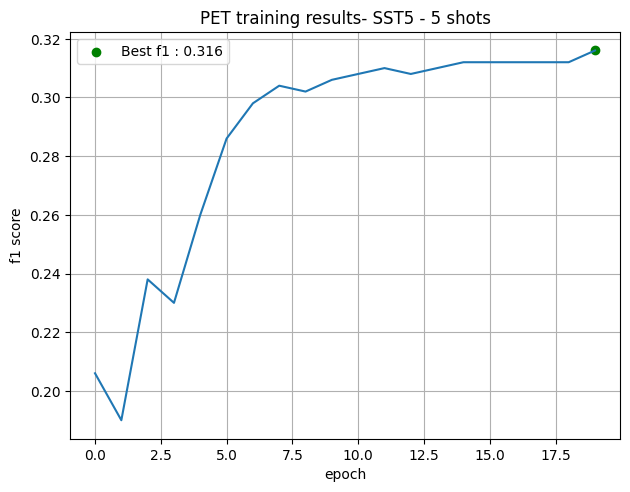

In [83]:
plt.plot(history)
plt.scatter(
    [best_epoch], 
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title(f"PET training results- {dataset_name} - {n_shots} shots")

Text(0.5, 1.0, '\n    Confusion matrix\n    PET - 5 shots SST5\n')

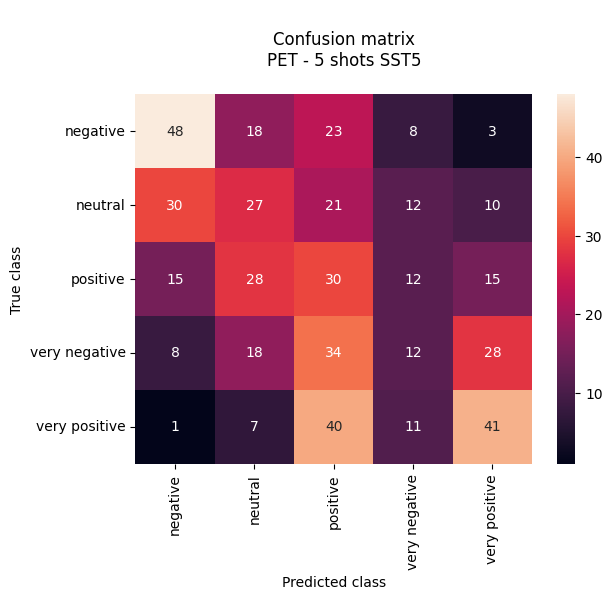

In [84]:
confusion_df = pd.DataFrame(confusion_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in classes2idx.items()})\
    .rename(index = {v:k for k, v in classes2idx.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix
    PET - {n_shots} shots {dataset_name}
''')

## 10 shots

In [85]:
n_shots = 10

In [86]:
train_text, train_labels = get_n_shots_per_class(
    sst5_dataset['train']['text'],
    sst5_dataset['train']['label'],
    n_shots=n_shots,
    num_classes=num_classes
)
val_text, val_labels = get_n_shots_per_class(
    sst5_dataset['test']['text'],
    sst5_dataset['test']['label'],
    n_shots=100,
    num_classes=num_classes
)

In [87]:
processed_text_train, labels_train = preprocess(
    train_text,
    train_labels,
    pattern2
)

processed_text_val, labels_val = preprocess(
    val_text,
    val_labels,
    pattern2
)

In [88]:
train_dataset = PETDatasetForClassification(
    processed_text_train,
    labels_train,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)

In [89]:
train_dataloader = DataLoader(train_dataset)
val_dataloader =DataLoader(val_dataset)

In [90]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device)
model.resize_token_embeddings(len(tokenizer.vocab))

history, confusion_matrix = train(
    train_dataloader,
    val_dataloader,
    num_classes,
    model,
    verbalizer,
    tokenizer,
    alpha = 1e-5,
    n_epochs=20
)

total_history[f'{n_shots} shots'] = history

100%|██████████| 500/500 [00:05<00:00, 88.30it/s]


In [91]:
best_epoch = np.argmax(history)
best_f1 = np.max(history)

Text(0.5, 1.0, 'PET training results- SST5 - 10 shots')

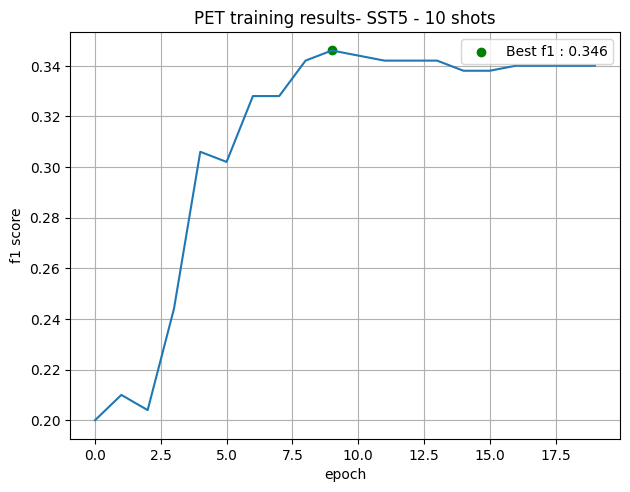

In [92]:
plt.plot(history)
plt.scatter(
    [best_epoch], 
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title(f"PET training results- {dataset_name} - {n_shots} shots")

Text(0.5, 1.0, '\n    Confusion matrix\n    PET - 10 shots SST5\n')

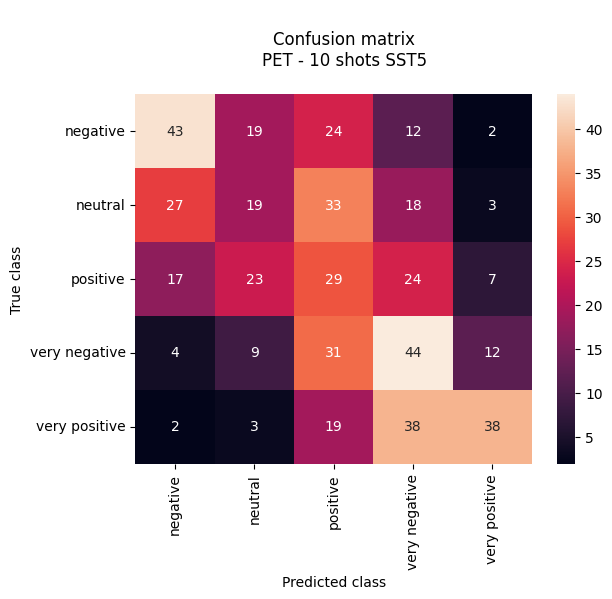

In [93]:
confusion_df = pd.DataFrame(confusion_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in classes2idx.items()})\
    .rename(index = {v:k for k, v in classes2idx.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix
    PET - {n_shots} shots {dataset_name}
''')

## History

Text(0.5, 1.0, 'PET training results- SST5')

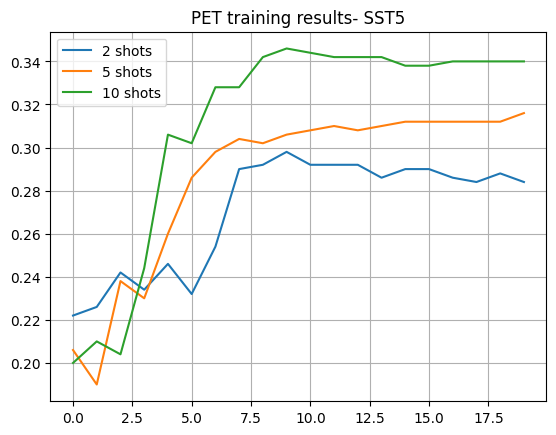

In [94]:
for k, v in total_history.items():
    plt.plot(
        v,
        label = k
    )

plt.grid()
plt.legend()
plt.title(f"PET training results- {dataset_name}")